In [10]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
#from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
sim_name = 'TNG100-1'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = ''
mass_multiplier = 1e10
log_mass_shift = 10

In [3]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'

with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

fn_dark_halo_arr = halo_params['halo']['fn_dark_halo_arr']

In [4]:
sim_reader = SimulationReader(halo_params['sim']['base_dir'], sim_name, sim_name_dark, 
                              halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()

In [63]:
sim_reader.add_catalog_property_to_halos('mass_hydro_subhalo_star')
sim_reader.add_catalog_property_to_halos('m200m')
sim_reader.add_catalog_property_to_halos('r200m')
#sim_reader.add_catalog_property_to_halos('v200m')

sim_reader.add_catalog_property_to_halos('x_minPE')
sim_reader.add_catalog_property_to_halos('x_minPE_hydro')

In [64]:
m_stellar = np.array([dark_halo.catalog_properties['mass_hydro_subhalo_star'] for dark_halo in sim_reader.dark_halo_arr])
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
r_200m = np.array([dark_halo.catalog_properties['r200m'] for dark_halo in sim_reader.dark_halo_arr])
#v_200m = np.array([dark_halo.catalog_properties['v200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_stellar = np.log10(m_stellar)
log_m_200m = np.log10(m_200m)
log_r_200m = np.log10(r_200m)
N_halos = len(sim_reader.dark_halo_arr)
print('N_halos:', N_halos)

N_halos: 19810


# MAH

In [25]:
sim_reader.add_MAH_to_halos_SAM()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/state/partition1/job-23989559/ipykernel_113911/2411934122.py", line 1, in <cell line: 1>
    sim_reader.add_MAH_to_halos_SAM()
  File "/home/ksf293/equivariant-cosmology/notebooks/../code/read_halos.py", line 337, in add_MAH_to_halos_SAM
    mtree = ilsam.merger.load_tree_haloprop(self.base_path_sam, root_idx,
  File "/home/ksf293/external/illustris_sam/merger.py", line 142, in load_tree_haloprop
    return load_tree(base_path, halo_id, 'Haloprop', fields, matches, most_massive)
  File "/home/ksf293/external/illustris_sam/merger.py", line 77, in load_tree
    idx = f['Offsets']['%sOffsets' % group][list(tree_dict['%sOffsets' % group])]
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.

In [ ]:
sim_reader.add_MAH_to_halos_sublink()

0
0 0
1000
1003 637821
2000
2004 713990
3000
3007 759746
4000
4014 791382
5000
5020 815717
6000
6024 835722
7000
7031 852398
8000
8040 866828
9000
9049 879559


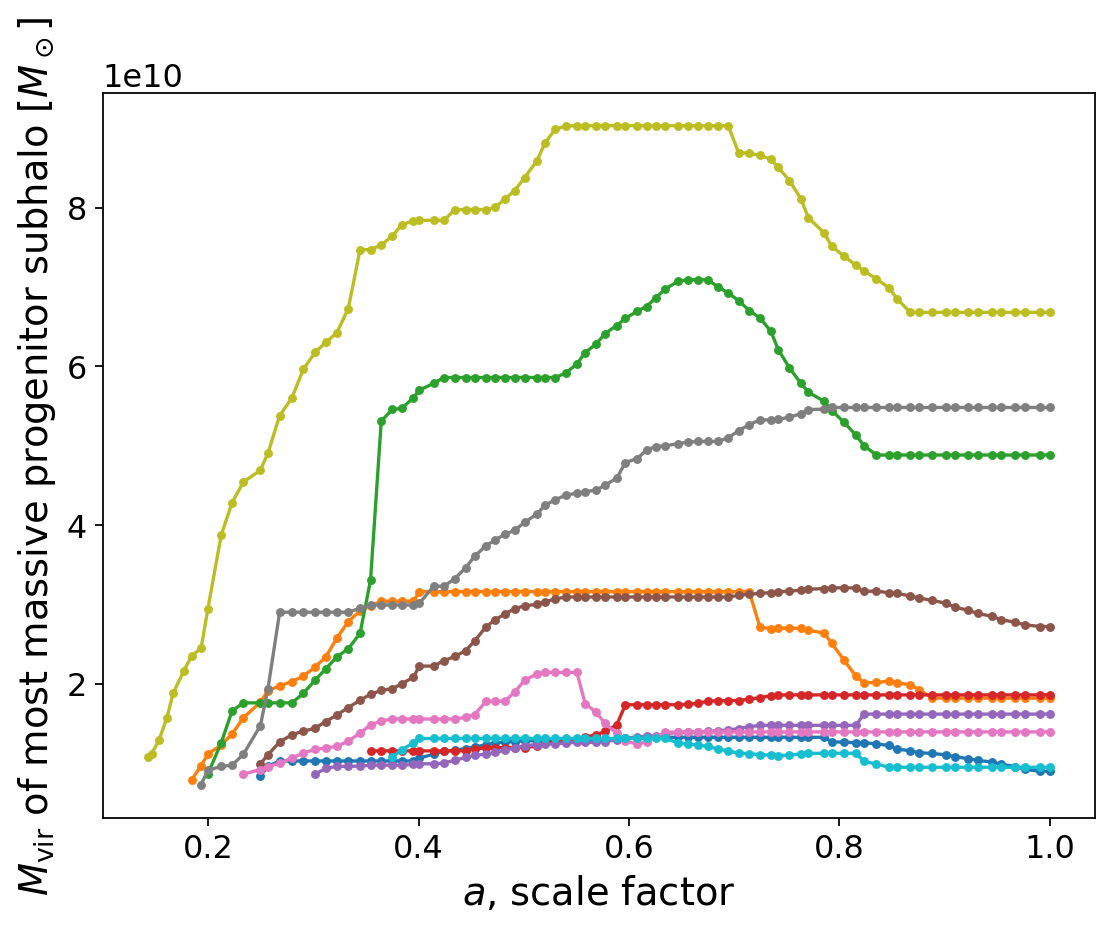

In [34]:
plt.figure(figsize=(8,6))
for i in range(10):
    halo = sim_reader.dark_halo_arr[i]
    a_mah, m_mah = halo.catalog_properties['MAH']
    plt.plot(a_mah, m_mah*mass_multiplier, marker='o', markersize=3)
    plt.xlabel(r'$a$, scale factor')
    plt.ylabel(r'$M_\mathrm{vir}$ of most massive progenitor subhalo [$M_\odot$]')

In [30]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [32]:
halo = sim_reader.dark_halo_arr[0]
a_mah, m_mah = halo.catalog_properties['MAH']
a75, idx_a75 = find_nearest(a_mah, 0.75)
print(a75, idx_a75)

0.75254 23


In [53]:
m75s = np.zeros(len(sim_reader.dark_halo_arr))
for i, halo in enumerate(sim_reader.dark_halo_arr):
    if 'MAH' not in halo.catalog_properties:
        continue
    if len(halo.catalog_properties['MAH'][1]) >= idx_a75+1:
        m75s[i] = halo.catalog_properties['MAH'][1][idx_a75]

In [56]:
print(np.min(m75s), np.max(m75s))

0.0 18478.0


Text(0.5, 0, '$M_\\mathrm{vir}$ of prog. subhalo at $a=0.75$ [$M_\\odot$]')

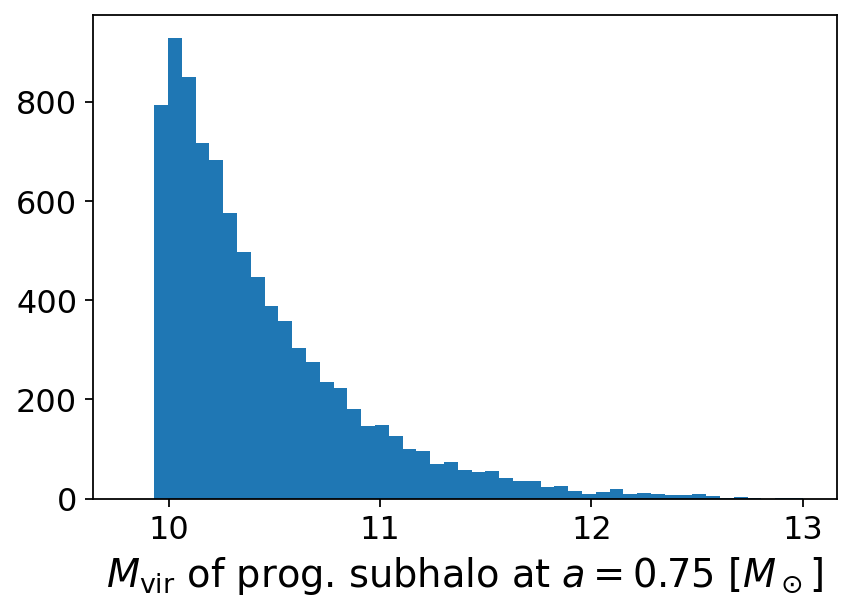

In [61]:
idx_nonzero = m75s > 0
bins = np.linspace(9.8, 13, 50)
plt.hist(np.log10(m75s[idx_nonzero] * mass_multiplier), bins=bins)
plt.xlabel('$M_\mathrm{vir}$ of prog. subhalo at $a=0.75$ [$M_\odot$]')

Text(0, 0.5, '$M_\\mathrm{vir}$ of prog. subhalo at $a=0.75$ [$M_\\odot$]')

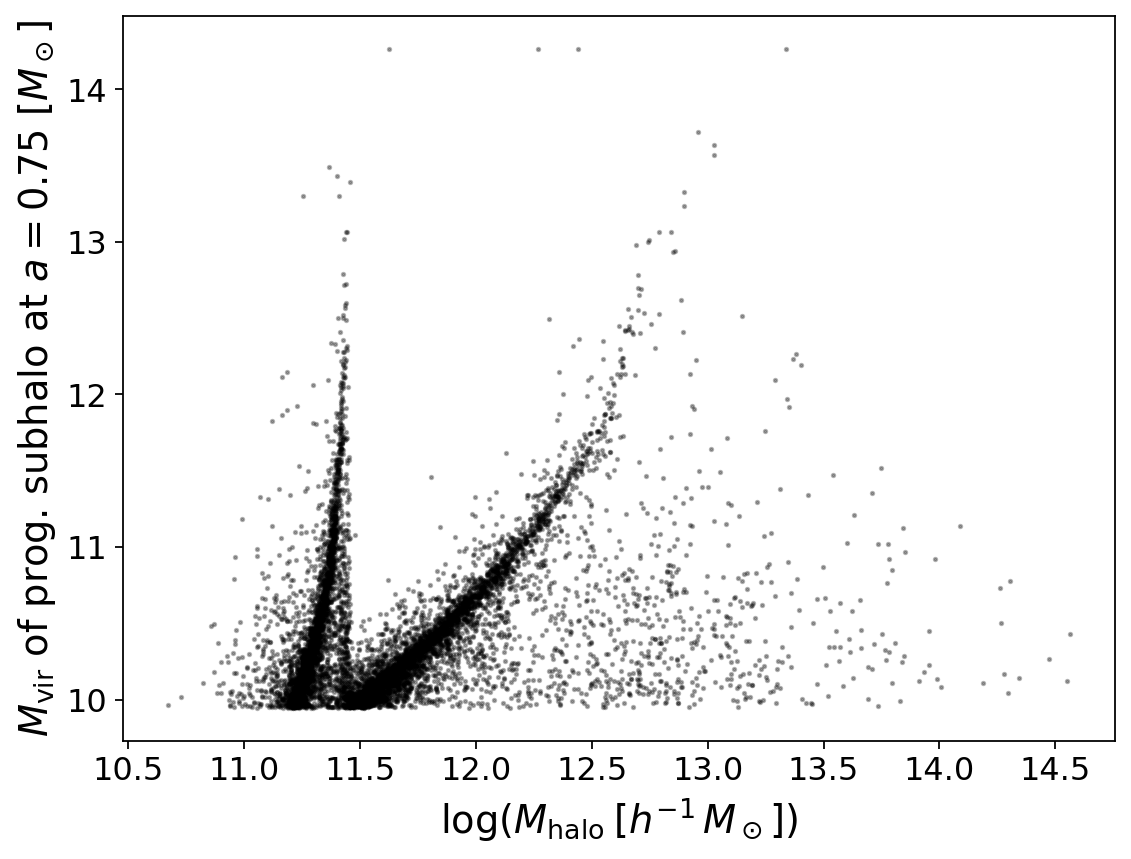

In [71]:
plt.figure(figsize=(8,6))
plt.scatter(log_m_200m[idx_nonzero] + log_mass_shift, np.log10(m75s[idx_nonzero] * mass_multiplier), 
            color='k', alpha=0.3, s=2)

plt.xlabel(utils.label_dict['m_200m'])
plt.ylabel('$M_\mathrm{vir}$ of prog. subhalo at $a=0.75$ [$M_\odot$]')